Necessary imports
dataset: Represents mutations
model: GNN


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("./src")


from src.make_dataset import make_dataset
from src.dataset import MutationDataset
from src.model import ProBindNN
from src.train import train
from src.visualize import comparator


from torch_geometric.loader import DataLoader
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR


import copy
import os
import time
from datetime import datetime



/home/babaid/miniconda3/envs/bio/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
To use the Graphein submodule graphein.protein.features.sequence.embeddings, you need to install: biovec 
biovec cannot be installed via conda
To use the Graphein submodule graphein.protein.visualisation, you need to install: pytorch3d 
To do so, use the following command: conda install -c pytorch3d pytorch3d


Make the dataset if needed

In [ ]:
make_dataset(index_xlsx="../index.xlsx", root="../dataset")

Dataset/dataloaders

In [19]:
dataset = MutationDataset(index_xlsx="index.xlsx", root="cancer_dataset")
train_size = int(len(dataset)*0.9)
val_size = len(dataset)-train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=True)
loaders = {"val_loader": val_loader, "train_loader":train_loader}

In [13]:
print("Length test dataset: ", len(val_dataset))
print("Length train dataset: ", len(train_dataset))
print("Take a look at the data: ", dataset[0])

Length test dataset:  495
Length train dataset:  4448
Take a look at the data:  {'mutated': Data(x=[71, 11], edge_index=[2, 109], edge_weights=[109], ddg=-1.47152859), 'non_mutated': Data(x=[71, 11], edge_index=[2, 109], edge_weights=[109])}


In [5]:
#CUDA/CPU Training
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [6]:

model = ProBindNN().to(device)

#Uncomment next line if you have  a pretrained model
model.load_state_dict(torch.load("models/model_2022_09_02_14_18_22.pt"))


<All keys matched successfully>

Optimizer and Loss Function and Scheduler

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
scheduler = ExponentialLR(optimizer, gamma=0.9)
loss_fn =  nn.MSELoss()

In [ ]:
best_model, path = train(model, loaders, optimizer, loss_fn, scheduler, n_epochs=1500)

100%|██████████| 4943/4943 [02:51<00:00, 28.78it/s]


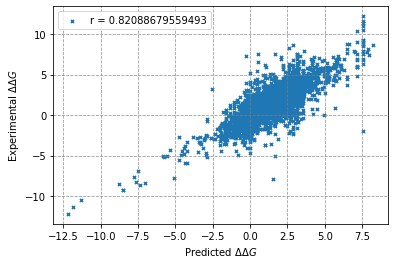

In [12]:
#change path to point to your model if available

#model.load_state_dict(torch.load(path))
 
#identifier for saved datapoints

t = time.time()
stamp = datetime.utcfromtimestamp(t).strftime('%Y_%m_%d_%H_%M_%S')

N = len(dataset)

comparator(model,dataset, N, "_data/predictions/{}_.csv".format(stamp))

In [20]:
from tqdm import tqdm
import numpy as np
xs = []
ys = []
model.eval()

for i in tqdm(range(len(dataset))):
    x, y, = dataset[i]["mutated"].to(device), dataset[i]["non_mutated"].to(device)
    ddg = dataset[i]["mutated"].ddg
    xs.append(model(x, y).squeeze().item())
    ys.append(ddg)
xs = np.array(xs)
ys = np.array(ys)

100%|██████████| 500/500 [00:12<00:00, 41.54it/s]


In [25]:
dataset.raw_file_names

['1n8z_GC19Q.pdb',
 '1n8z_KA6W.pdb',
 '1n8z_EA12K.pdb',
 '1n8z_GA19Q.pdb',
 '1n8z_KC6Q.pdb',
 '1n8z_GC19H.pdb',
 '1n8z_HB3W.pdb',
 '1n8z_MB25M.pdb',
 '1n8z_LC24V.pdb',
 '1n8z_EC12G.pdb',
 '1n8z_VC14H.pdb',
 '1n8z_MC25K.pdb',
 '1n8z_KA18G.pdb',
 '1n8z_KC18T.pdb',
 '1n8z_IB22H.pdb',
 '1n8z_GA19E.pdb',
 '1n8z_IA22P.pdb',
 '1n8z_EB12E.pdb',
 '1n8z_FB9E.pdb',
 '1n8z_AA11I.pdb',
 '1n8z_LA24K.pdb',
 '1n8z_QC5P.pdb',
 '1n8z_KB18E.pdb',
 '1n8z_LA24F.pdb',
 '1n8z_IC22V.pdb',
 '1n8z_MC25Y.pdb',
 '1n8z_IC22P.pdb',
 '1n8z_LB7Q.pdb',
 '1n8z_LB7K.pdb',
 '1n8z_FB9M.pdb',
 '1n8z_VB14S.pdb',
 '1n8z_GA19C.pdb',
 '1n8z_VB14W.pdb',
 '1n8z_LC24D.pdb',
 '1n8z_HC3G.pdb',
 '1n8z_GB15Y.pdb',
 '1n8z_SA16L.pdb',
 '1n8z_AC11H.pdb',
 '1n8z_KA6Y.pdb',
 '1n8z_KC6L.pdb',
 '1n8z_VA26F.pdb',
 '1n8z_VA26E.pdb',
 '1n8z_SA16F.pdb',
 '1n8z_VA26Q.pdb',
 '1n8z_KA18K.pdb',
 '1n8z_HC4Q.pdb',
 '1n8z_SB16D.pdb',
 '1n8z_LC7L.pdb',
 '1n8z_HC4Y.pdb',
 '1n8z_GA19A.pdb',
 '1n8z_SB16L.pdb',
 '1n8z_SB16T.pdb',
 '1n8z_FB9C.pdb',
 '1n8z_F

0.8795818876485474

If you want to take a look at the raw predictions_

In [8]:
model.eval()
d = next(iter(train_loader))
model(d["mutated"].cuda(), d["non_mutated"].cuda()).squeeze()

tensor(3.2161, device='cuda:0', grad_fn=<SqueezeBackward0>)

In [ ]:
from graphein.protein.graphs import construct_graph
from graphein.ml.conversion import GraphFormatConvertor
from graphein.protein.edges.atomic import add_atomic_edges, add_bond_order, add_ring_status
from graphein.protein.edges.distance import add_hydrogen_bond_interactions, add_ionic_interactions, add_peptide_bonds
from graphein.protein.visualisation import plotly_protein_structure_graph
from graphein.protein.config import ProteinGraphConfig

params_to_change = {"granularity": "atom", "edge_construction_functions": [add_atomic_edges, add_bond_order, add_hydrogen_bond_interactions, add_ionic_interactions, add_peptide_bonds]}
config = ProteinGraphConfig(**params_to_change)
graph_mutated = construct_graph(config=config,pdb_path="datasetmf/raw/temp/1_mutated_interface.pdb")


p = plotly_protein_structure_graph(
    graph_mutated,
    colour_edges_by="kind",
    colour_nodes_by="element_symbol",
    label_node_ids=False,
    node_size_min=5,
    node_alpha=0.85,
    node_size_multiplier=1,
    plot_title="Atom-level graph. Nodes coloured by their Element"
    )
p.show()

Application to 6w0o

In [26]:
from src.utils import pdb_to_df , save_to_pdb
import numpy as np
from src.utils import STD_AMINO_CODES


len(STD_AMINO_CODES)

20

In [7]:
p = pdb_to_df("6w0o", "_data/test")
high = 27

NameError: name 'pdb_to_df' is not defined

In [46]:
n_mut = 2000
high = 28
mutations = np.random.randint(3, high, (n_mut))
mutate_to = np.random.randint(0, 20, (n_mut))
chains = [0] #np.random.randint(0, 3, (n_mut))

In [39]:
mutations.min()

3

In [10]:
def f(x):
    id = ["A", "B", "C"]
    return id[int(x)-1]
p.chain_id = p.chain_id.apply(f)

In [68]:
save_to_pdb(p, "PDBs/1n8z.pdb.pdb")

In [28]:
import pymol
pymol.cmd.load( "PDBs/1n8z.pdb.pdb")
#pymol.cmd.select("select chain A")
seqA = pymol.cmd.get_fastastr("chain 1")
seqB = pymol.cmd.get_fastastr("chain 2")
seqC = pymol.cmd.get_fastastr("chain 3")
pymol.cmd.reset()
pymol.cmd.delete("all")

 PyMOL not running, entering library mode (experimental)


In [2]:
seqA

'>1n8z.pdb_1\nYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVV\n'

In [29]:
seqA = seqA.split("\n")[1]
seqB = seqB.split("\n")[1]
seqC = seqC.split("\n")[1]

In [30]:
seq_lst = [[ch for ch in seq] for seq in [seqA, seqB, seqC]]

In [6]:
len(seq_lst[0])

31

In [31]:
import pandas as pd

In [32]:
len(seq_lst)

3

In [36]:
chains_str = ["A", "B", "C"]

In [47]:
pdbid = "1n8z"
muts =  list(STD_AMINO_CODES.keys())
index_xlsx = []
for i in range(n_mut):
    
    chain = chains_str[0]
    
    m_from = seq_lst[0][mutations[i]]
    
    to = muts[mutate_to[i]]
    mut_id = m_from + chain + str(mutations[i]) + to
    row = [pdbid, mut_id, 0.0]
    index_xlsx.append(row)
d = pd.DataFrame(index_xlsx, columns=["pdb_id", "mut_id", "ddg"]).drop_duplicates()
d.to_excel("1n8z.xlsx")

In [11]:
p.loc[p.chain_id == "A"]

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,,TYR,,A,10,,...,192.284,258.656,212.855,1.0,0.0,,A,N,NaN,0
1,ATOM,2,,CA,,TYR,,A,10,,...,192.122,258.900,214.315,1.0,0.0,,A,C,NaN,1
2,ATOM,3,,C,,TYR,,A,10,,...,191.460,257.689,214.965,1.0,0.0,,A,C,NaN,2
3,ATOM,4,,O,,TYR,,A,10,,...,191.658,257.424,216.150,1.0,0.0,,A,O,NaN,3
4,ATOM,5,,CB,,TYR,,A,10,,...,191.260,260.147,214.530,1.0,0.0,,A,C,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,ATOM,464,,HG12,,VAL,,A,40,,...,239.055,190.111,210.913,1.0,0.0,,A,H,NaN,463
464,ATOM,465,,HG13,,VAL,,A,40,,...,237.369,190.118,211.400,1.0,0.0,,A,H,NaN,464
465,ATOM,466,,HG21,,VAL,,A,40,,...,240.687,188.627,213.109,1.0,0.0,,A,H,NaN,465
466,ATOM,467,,HG22,,VAL,,A,40,,...,239.440,187.531,212.523,1.0,0.0,,A,H,NaN,466
